In [1]:
%load_ext autoreload
%autoreload 2
# Add parent directory into system path
import sys, os
sys.path.insert(1, os.path.abspath(os.path.normpath('..')))

import numpy as np
from sdf import *
from scipy.stats import describe

import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm

def removeOutliers(x, outlierConstant=1.5):
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
    
    result = a[np.where((a >= quartileSet[0]) & (a <= quartileSet[1]))]
    
    return result

@sdf3
def gyroid(w = 3.14159, t=0):
    def f(p):
        q = w*p
        x, y, z = (q[:, i] for i in range(3))
        return (np.cos(x)*np.sin(y) + np.cos(y)*np.sin(z) + np.cos(z)*np.sin(x) - t)
    return f

def _plot(lvl_set, gradient=None):
    
    _, ax = plt.subplots()
    plt.pcolormesh(lvl_set, cmap='coolwarm', norm=CenteredNorm())
    plt.colorbar()
    ax.set_title('min=%.6f max=%.6f' % (np.min(lvl_set), np.max(lvl_set)))
    ax.tick_params(axis='both', which='major', labelsize=6)
    plt.show()

    if gradient is not None:
        _, ax = plt.subplots()
        plt.pcolormesh(gradient-1, cmap='coolwarm', norm=CenteredNorm())
        plt.colorbar()
        ax.set_title('min=%.6f max=%.6f' % (np.min(gradient-1), np.max(gradient-1)))
        ax.tick_params(axis='both', which='major', labelsize=6)
        #c.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x:,.2f}'))
        #c.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x:,.2f}'))
        plt.show()

dataset_name = '../datasets/box_1f0_gyroid_4pi_10K_100K'
train_filename = dataset_name + '_train.npz'
test_filename = dataset_name + '_test.npz'
slice_filename = dataset_name + '_slice.npz'
output_stl = dataset_name + '.stl'

train = ImplicitDataset.from_file(train_filename)
test = TestDataset(test_filename)
slice_dataset = SliceDataset.from_file(slice_filename)

In [30]:
from sdf.mesh import _estimate_bounds, _cartesian_product

# Generate STL from implicit f
output_stl = 'tmp.stl'
f = box(1) & gyroid(w=12)
f.save(output_stl, step=0.01)

from utils import igl
print(os.path.exists(output_stl))
_v, _f = igl.read_triangle_mesh(output_stl)
bv, bf = igl.bounding_box(_v)

# calcualte lvl_set of f
nums = 100
offset = .1
#bounds = _estimate_bounds(f)
bounds = (bv[0], bv[-1]) if np.mean(bv[0]) < np.mean(bv[-1]) else (bv[-1], bv[0])
(x0, y0, z0), (x1, y1, z1) = bounds

X = np.linspace(x0-offset, x1+offset, nums, dtype=np.float32)
Y = np.linspace(y0-offset, y1+offset, nums, dtype=np.float32)
Z = np.linspace(z0-offset, z1+offset, nums, dtype=np.float32)

P = _cartesian_product(X, Y, Z).astype(np.float32)
lvl_set = f(P).astype(np.float32)

min -0.565721, -0.565721, -0.565721
max 0.565722, 0.565722, 0.565722
step 0.01, 0.01, 0.01

248028 triangles in 0.403996 seconds
True


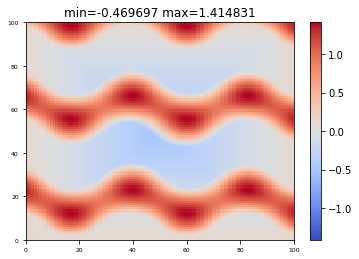

In [31]:
_plot(lvl_set.reshape((nums, nums, nums))[:,:,nums//2])

0.0008699551
DescribeResult(nobs=33578, minmax=(1.5366837e-07, 0.017908614), mean=0.0030086613, variance=4.829628e-06, skewness=1.0020213187184963, kurtosis=1.4375422059294447)


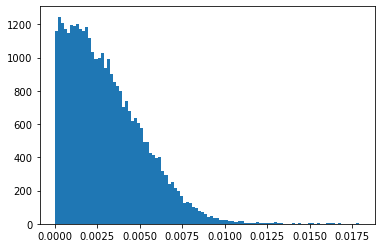

33370 0.9938054678658645


In [32]:
# collect the points that |lvl_set| < atol
atol=0.01
_zero_mark = np.squeeze(np.isclose(lvl_set, np.zeros_like(lvl_set), atol=atol))
bc_points = P[_zero_mark]
filtered_lvl_sets = lvl_set[_zero_mark].squeeze()

sdfs, _, _ = igl.signed_distance(bc_points, _v, _f, 4, return_normals=False)

err = np.abs(filtered_lvl_sets - sdfs)
print(np.mean(err))
relative_err = removeOutliers(err / np.abs(filtered_lvl_sets), 1.5)

print(describe(relative_err))
import matplotlib.pyplot as plt
plt.hist(relative_err, bins=100)
plt.show()

alpha = 0.01
N_less_alpha = np.sum(relative_err <= alpha)
ratio_less_alpha = np.sum(relative_err <= alpha) / relative_err.shape[0]
print(N_less_alpha, ratio_less_alpha)